# Peak over threshold method

This notebook details the peak-over-threshold method which is commonly used in analyzing sea level extremes. The goal of the peak-over-threshold method is to typically determine return levels (such as an extreme sea level which would occur only once a year or once every hundred years.

Contents:
* [Generate data](#Generate-data)
* [Select subset of extreme values](#Select-subset-of-extreme-values)
* [Fit extreme value distribution to extreme values](#Fit-extreme-value-distribution-to-extreme-values)
* [Determine return levels using CDF of fitted values](#Determine-return-levels-using-CDF-of-fitted-values)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(0)

## Generate data

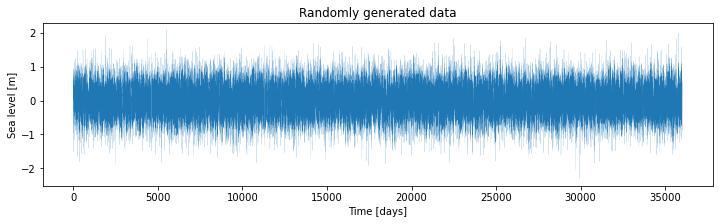

In [71]:
N = 36_000 # For example, for ~100 years of data
time = np.arange(N)
sea_level = rng.normal(scale=0.5, size=N)

fig, ax = plt.subplots(figsize=(12,3))
ax.plot(time, sea_level, lw=0.1)
ax.set(
    title = 'Randomly generated data',
    xlabel='Time [days]',
    ylabel='Sea level [m]'
);

## Select subset of extreme values

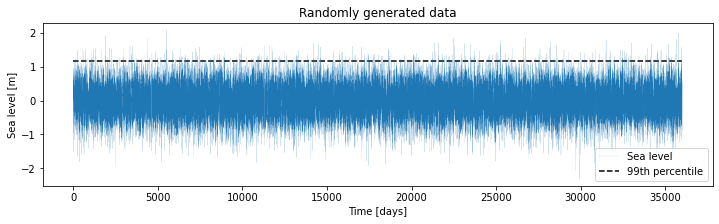

In [72]:
# Select subset of extreme values (those in the 95th percentile)
q = 0.99
quantile = np.quantile(sea_level, q)
extremes = sea_level[sea_level > quantile]

fig, ax = plt.subplots(figsize=(12,3))
ax.plot(time, sea_level, lw=0.1, label='Sea level')
ax.hlines(quantile, 0, N, ls='--', color='k', label='{}th percentile'.format(int(q*100)))
ax.set(
    title = 'Randomly generated data',
    xlabel='Time [days]',
    ylabel='Sea level [m]'
);
ax.legend();

## Fit extreme value distribution to extreme values

In [85]:
# Fit generalized pareto distribution to extreme values
from scipy.stats import genpareto

# Note: location parameter is set to the minimum of extremes.
# This implicitly assumes that we have enough data, and the
# distribution is concentrated towards lower values. However, 
# leaving out the `floc` parameter can result in poorly fitted
# MLE distributions to the data.
fitted_params = genpareto.fit(
    extremes,
    floc=np.min(extremes)
)
shape, loc, scale = fitted_params
print('Shape:\t', shape)
print('Loc:\t', loc)
print('Scale:\t', scale)

Shape:	 -0.05717160708309734
Loc:	 1.1654684861993325
Scale:	 0.17599524133615585


Try fiddling with kwargs to genpareto.fit. You can probably do better by manually setting the location and/or scale parameters to the extreme value data you have. Right now, the problem is with the shape parameter being less than -1, in which case the PDF is monotonically increasing on its compact support.

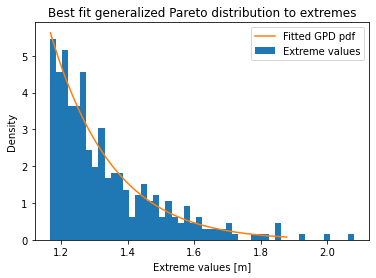

In [86]:
fig, ax = plt.subplots()
quantiles = np.linspace(
    genpareto.ppf(0.01, *fitted_params),
    genpareto.ppf(0.99, *fitted_params),
    99
)
fitted_pdf = genpareto.pdf(quantiles, *fitted_params)
ax.hist(extremes, bins=50, density=True, label='Extreme values')
ax.plot(quantiles, fitted_pdf, label='Fitted GPD pdf')
ax.set(
    title='Best fit generalized Pareto distribution to extremes',
    xlabel='Extreme values [m]',
    ylabel='Density'
);
ax.legend(loc='upper right');

## Determine return levels using CDF of fitted values

In [87]:
T = 365     # Return period (e.g., once-per-year for daily observations)
p = 1/T
z_T = loc + scale/shape * ((genpareto.sf(loc, *fitted_params)/p)**scale - 1)

z_T

-4.4512094322941405

Totally wrong.